# 原始訊號raw data與濾波後訊號

In [1]:
import h5py
import numpy as np
import os
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="white", font_scale=2)
df = pd.DataFrame(columns=['time (s)', 'amplitude (mV)', 'filtered amplitude (mV)', 'channel'])

In [2]:
def _pad(nwb_T, fs):
    idx_0 = np.where(nwb_T==0)[0]
    nwb_TT = np.copy(nwb_T)
    for i in idx_0:
        # print(i)
        if i!=0:
            nwb_TT[i] = nwb_T[i-1] + 1/fs
    return nwb_TT

In [3]:
nwb_path = '/home/jovyan/dataset/indy/The_nwb_Raw_Dataset'    #改路徑，資料夾裡面只能放.nwb
nwb_list = os.listdir(nwb_path)
path = '/acquisition/timeseries/broadband/data'
timestampPath = '/acquisition/timeseries/broadband/timestamps'

In [4]:
CH_sig = []

nwb_f = nwb_list[0]    #第幾個.nwb
Ses_n = nwb_f.split('.')[0]
nwb_fp = os.path.join(nwb_path, nwb_f)
nwbfile = h5py.File(nwb_fp, 'r')

nwb_D = nwbfile[path]
nwb_T = np.array(nwbfile[timestampPath])
fs = round(1/(nwb_T[1] - nwb_T[0]), 3)
nwb_T = _pad(nwb_T, fs)

rmin, rmax = 28000, 28000+12500    #時間區段
for c in [0, 31, 63, 95]:    #channel
    CH_sig.append(str(c+1))
    nwb_D_ch = np.array(nwb_D[rmin:rmax, c]).astype(float)
    nwb_T_ch = np.round(nwb_T[rmin:rmax].astype(float), 5)

    # Low pass
    b, a = signal.butter(4, [500, 5000], 'bandpass', fs=fs)
    nwb_D_ch_low = signal.filtfilt(b, a, nwb_D_ch).astype(float)

    # Dataframe
    CH = [str(c+1) for i in range(len(nwb_D_ch))]
    df_dict = {'channel': CH,
            'amplitude (mV)': nwb_D_ch,
            'time (s)': nwb_T_ch,
            'filtered amplitude (mV)': nwb_D_ch_low}

    df_ = pd.DataFrame(df_dict)
    df = df.append(df_)
    del df_
del nwb_D
del nwb_T

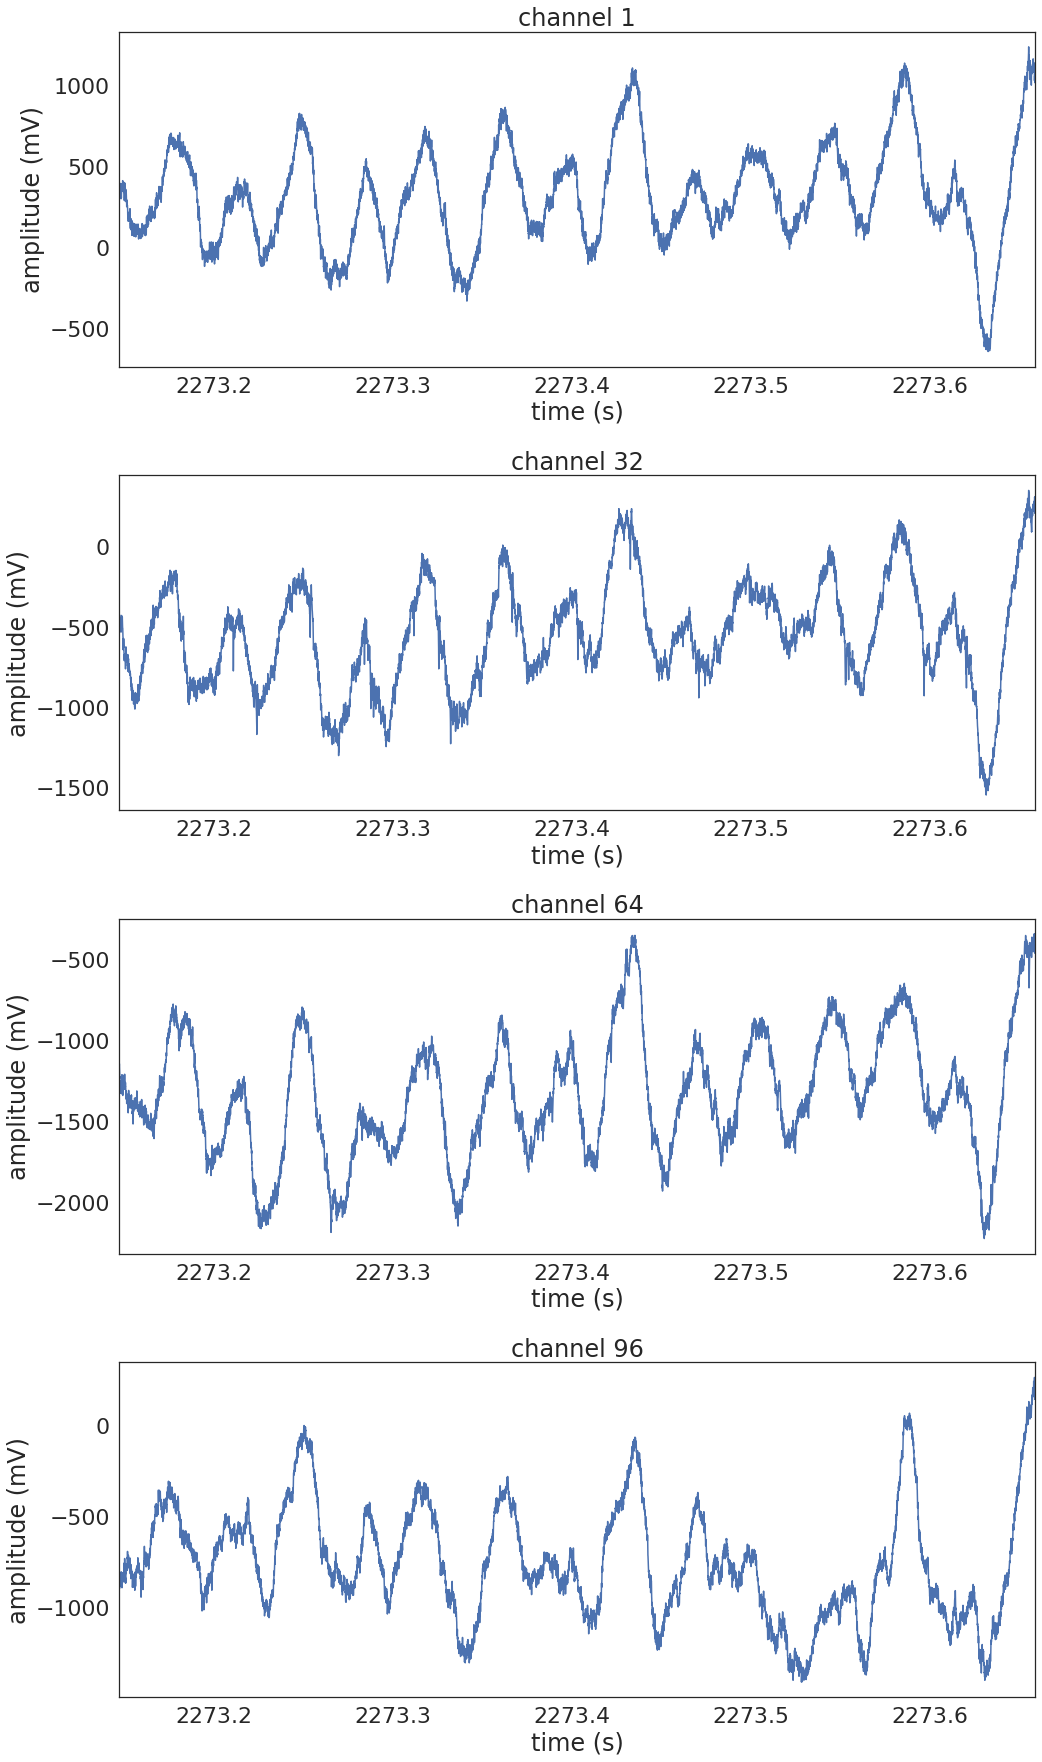

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(15, 25))
for i_ax in range(4):
    df_ = df[df.values==CH_sig[i_ax]]
    tmin = np.min(df_['time (s)'])
    tmax = np.max(df_['time (s)'])
    ax[i_ax].ticklabel_format(style='plain', useOffset=False, axis='both')
    sns.lineplot(data=df_, x='time (s)', y='amplitude (mV)', ax=ax[i_ax])
    ax[i_ax].set_xlim(tmin, tmax)
    ax[i_ax].set_title('channel ' + CH_sig[i_ax])
    
plt.tight_layout()

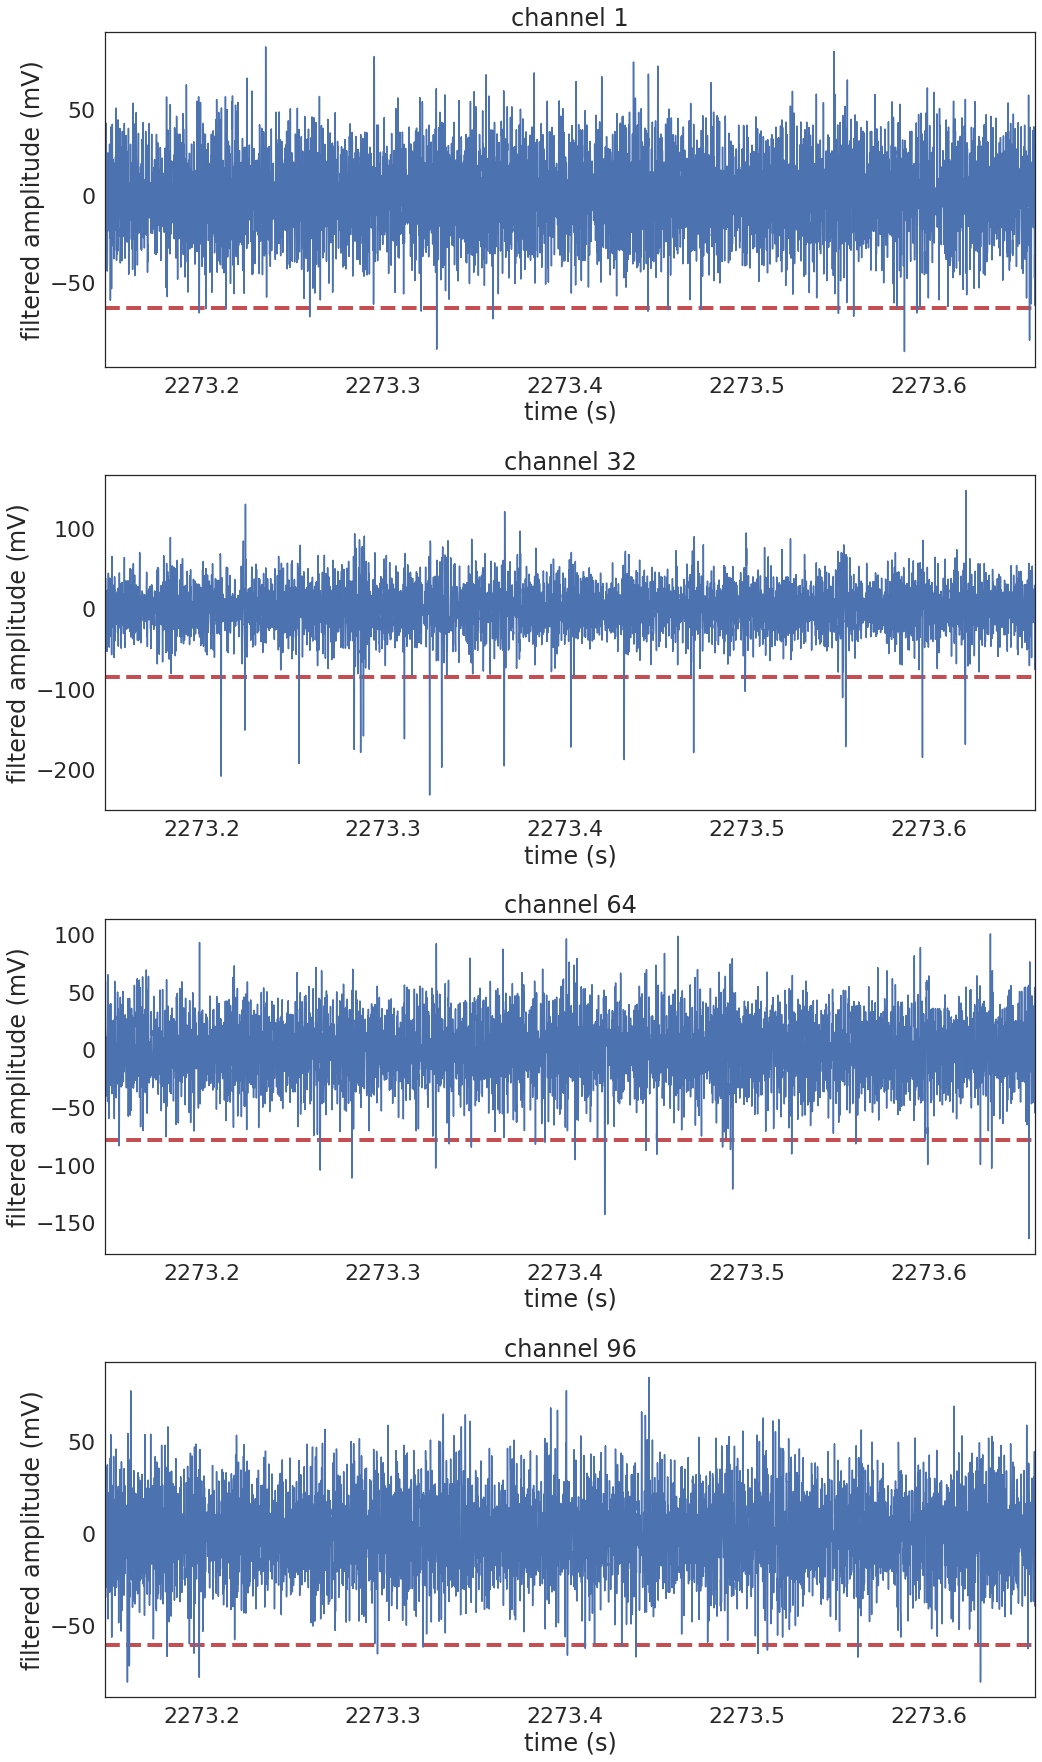

In [6]:
fig, ax = plt.subplots(4, 1, figsize=(15, 25))
for i_ax in range(4):
    df_ = df[df.values==CH_sig[i_ax]]
    std = -3 * np.std(df_['filtered amplitude (mV)'].values)
    ax[i_ax].ticklabel_format(style='plain', useOffset=False, axis='both')
    ax[i_ax].axhline(y=std, linestyle='--', color='r', linewidth='4')
    sns.lineplot(data=df_, x='time (s)', y='filtered amplitude (mV)', ax=ax[i_ax])

    ax[i_ax].set_xlim(np.min(df_['time (s)']), np.max(df_['time (s)']))
    ax[i_ax].set_title('channel ' + CH_sig[i_ax])
    
plt.tight_layout()